- title: My notebook
- author: Amol Kelkar
- date: 2018-10-01
- category: ai
- tags: keras, lstm, rnn, online learning

# LSTM with single merged sample

In [1]:
# ref https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)
    
def random_sample(len_ts=3000,D=1001):
    c_range = range(5,100)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    
    y1 = np.zeros(len_ts)

    for t in range(D,len_ts):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2]*x1[t-D] 
    y = np.array([y1]).T
    X = np.array([x1]).T
    return y, X

def generate_data(D= 1001,Nsequence = 1000,T=4000, seed=123):
    X_train = []
    y_train = []
    set_seed(sd=seed)
    for isequence in range(Nsequence):
        y, X = random_sample(T,D=D)
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

D = 100 
T = 1000
ns = 16
X, y = generate_data(D=D,T=T,Nsequence = ns)
X = np.reshape(X, (1, T*ns, 1))
y = np.reshape(y, (1, T*ns, 1))
print(X.shape, y.shape)

def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(20,12))
    fig.subplots_adjust(hspace = 0.4,wspace = 0.20)
    count = 1
    n_ts = 16
    for irow in range(n_ts):
        ax = fig.add_subplot(n_ts/4,4,count)
        ax.set_ylim(-0.5,0.5)
        ax.plot(X[0,irow*T:irow*T+T,0],"--",label="x1")
        ax.plot(y[0,irow*T:irow*T+T,:],label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[0,irow*T:irow*T+T,:],label=nm)   
        count += 1
    plt.legend()
    plt.show()
#     if ypreds is not None:
#         for y_pred, nm_ypred in zip(ypreds,nm_ypreds):
#             loss = np.mean( (y_pred[:,D:,:].flatten() - y[:,D:,:].flatten())**2)
#             print("The final validation loss of {} is {:7.6f}".format(
#                 nm_ypred,loss))
        
plot_examples(X,y,ypreds=None,nm_ypreds=None)

# prop_train = 0.8
# ntrain = int(X.shape[0]*prop_train)

# w = np.zeros(y.shape[:2])
# w[:,D:] = 1 
# w_train = w

# X_train, X_val = X[:ntrain], X[ntrain:]
# y_train, y_val = y[:ntrain], y[ntrain:]
# w_train, w_val = w[:ntrain], w[ntrain:]

Using TensorFlow backend.


python 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
keras version 2.2.2
tensorflow version 1.10.0
(1, 16000, 1) (1, 16000, 1)


<Figure size 2000x1200 with 16 Axes>

In [2]:
from keras import models, layers

def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

X_train = X
y_train = y
hunits = 64
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16000, 1)          0         
_________________________________________________________________
RNN (LSTM)                   (None, 16000, 64)         16896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16000, 1)          65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=1,
                             epochs=20,
                             verbose=2)
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

for label in ["loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.show()

Epoch 1/20
 - 11s - loss: 0.0040
Epoch 2/20
 - 11s - loss: 0.0040
Epoch 3/20
 - 12s - loss: 0.0040
Epoch 4/20


KeyboardInterrupt: 

In [9]:
X_test, y_test = generate_data(D=D,T=T,Nsequence = ns)
X_test = np.reshape(X_test, (1, T*ns, 1))
y_test = np.reshape(y_test, (1, T*ns, 1))



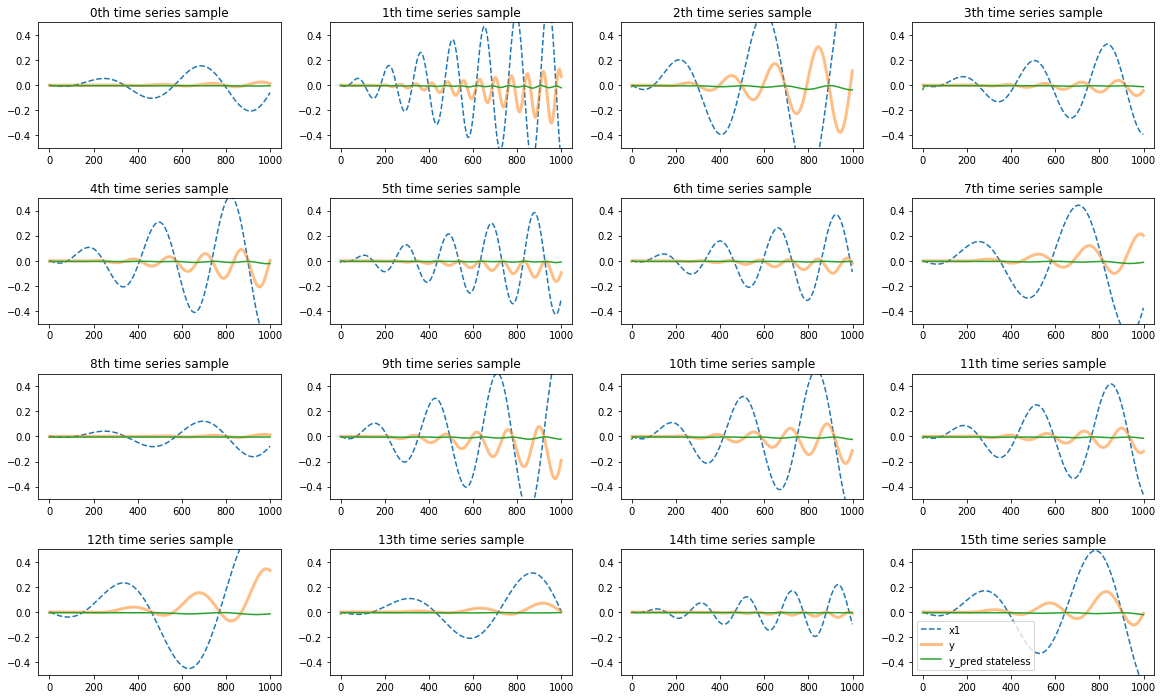

In [11]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])